# Accelerating Arid vegetation patterns - ctypes
Although the Klausmeier model is not marine, we use it in this marine course because of the model's conciseness. This one is not very compute efficient.
### Loading some crucial python packages

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import time
%matplotlib inline

# Widening the screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

### Parameter definitions 

Here, the parameters that are found in the equations are given their value. For completeness, also their units and explanations are given.

In [15]:
# Parameters       Original value    Explanation and Units
a        = 1.5     # 2.0             Rainfall rate
m        = 0.45    # 0.45            Mortality rate

v        = 182.0   # 182             The downslope advection of W 
dw       = 10.0    # 10              The diffusion constant of W
dn       = 1.0     # 1.0             The diffusion constant of N

### Simulation parameters

In [3]:
EndTime  =  50.0    # total runtime
dT       = .001    # time step
NumPlots = 100     # number of plot updates

Size           = 512
Grid_Width     = Size     # size of the 2D grid
Grid_Height    = Size
LengthX        = Size    # length of the domain, forces as a float with a .
LengthY        = Size    # length of the domain, forces as a float with a .

### Precalculations

In [4]:
dX = LengthX/Grid_Width  # Space step in X
dY = LengthY/Grid_Height # Space step in Y
n = int(EndTime/NumPlots/dT)

### Below, I auto-generate the "MusselParameters.h" file from the variables listed in the PassVars string.

In [5]:
# List of parameters for the OpenCL kernel. Seperate with comma without spaces
PassVars="a,m,v,dw,dn,dT,dX,dY,n,Grid_Width,Grid_Height"

# Setting up the parameters for the Kernel
PassVals=eval(PassVars)        # Contains a list of the values
PassVars=PassVars.split(',')   # Contains a list of the Parameter names
Params=""

for ii in range(len(PassVals)):
    Params = Params+"#define " + PassVars[ii] + " " + str(PassVals[ii]) + " \n" 
    
print(Params,  file=open('AridParameters.h', 'w'))    

In [6]:
%%writefile AridKernel.c

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include "AridParameters.h"

////////////////////////////////////////////////////////////////////////////////
// Laplacation operator definition, to calculate diffusive fluxes
////////////////////////////////////////////////////////////////////////////////

float d2_dxy2(float* pop, int row, int column)
{
    float retval;
    float dx = dX;
    float dy = dY;
    
    int current = row * Grid_Width + column;
    int left    = row * Grid_Width + column-1;
    int right   = row * Grid_Width + column+1;
    int top     = (row-1) * Grid_Width + column;
    int bottom  = (row+1) * Grid_Width + column;
    
    retval = ( ( pop[left] + pop[right]  - 2*pop[current] ) /dx/dx +
               ( pop[top]  + pop[bottom] - 2*pop[current] ) /dy/dy );
    
    return retval;
}

////////////////////////////////////////////////////////////////////////////////
// Gradient operator definition, to calculate advective fluxes
////////////////////////////////////////////////////////////////////////////////


float d_dy(float* pop, int row, int column)
{
    float retval;
    int current, top;
    float dy = dY;
    
    current=row * Grid_Width + column;
    top=(row-1) * Grid_Width + column;
     
    retval =  (( pop[current] - pop[top] )/dy );
    
    return retval;
}

////////////////////////////////////////////////////////////////////////////////
// Simulation kernel
////////////////////////////////////////////////////////////////////////////////

void AridKernel ( float* W, float* N)
{
    for (size_t rep=0; rep<n; rep++)
        for (size_t row=0; row<Grid_Height; row++)
            for (size_t column=0; column<Grid_Width; column++){
                size_t current=row*Grid_Width+column;
                if(row > 0 && row < Grid_Height-1 && column > 0 && column < Grid_Width-1)
                {
                    float Consumption = W[current] * N[current] * N[current];
                    float drW = a - W[current] - Consumption - v*d_dy(W,row,column) + dw*d2_dxy2(W,row,column);
                    float drN = Consumption - m*N[current] + dn*d2_dxy2(N,row,column);

                    W[current] = W[current] + dT*drW;
                    N[current] = N[current] + dT*drN;
                }

                // HANDLE Boundaries
                else if(row==0)
                //do copy of first row = second last row
                {
                    W[current]=W[(Grid_Height-2)*Grid_Width+column];
                    N[current]=N[(Grid_Height-2)*Grid_Width+column];
                }
                else if(row==Grid_Height-1)
                //do copy of last row = second row
                {
                    W[current]=W[1*Grid_Width+column];
                    N[current]=N[1*Grid_Width+column];
                }
                else if(column==0) // Left boundary
                {
                    W[current]=W[row * Grid_Width + 1];
                    N[current]=N[row * Grid_Width + 1];
                }
                else if(column==Grid_Width-1) // Right boundary
                {
                    W[current]=W[row * Grid_Width + Grid_Width-2];
                    N[current]=N[row * Grid_Width + Grid_Width-2];
                }
            }
    
} // End AridKernel


Overwriting AridKernel.c


In [7]:
!!gcc -shared -o AridKernel.so -fPIC AridKernel.c

[]

In [8]:
import ctypes
lib = ctypes.CDLL('AridKernel.so')
AridKernel = lib.AridKernel

In [9]:
from numpy.ctypeslib import ndpointer
# Define the types of the output and arguments of
# this function.
AridKernel.restype = None
AridKernel.argtypes = [ndpointer(ctypes.c_float),
                       ndpointer(ctypes.c_float)]

In [10]:
# Initializing the data arrays and giving them starting values
np.random.seed(10)
W = np.zeros((Grid_Width, Grid_Height), dtype=np.float32)+1.0
N = (np.random.rand(Grid_Width, Grid_Height)<0.05)*1.0 + 1.0
N = N.astype(np.float32)
    
Ns= np.zeros((Grid_Width, Grid_Height, NumPlots))

start_time = time.time() # Starting a timer

# We simulate the PDE with the finite difference method.
for count in range(NumPlots):    
    AridKernel(W, N)
    Ns[:,:,count]=N
    
print(" Simulation took      : %1.1f (s)" % (time.time() - start_time))    

 Simulation took      : 1046.5 (s)


### Colormap definitions

In [11]:
Vegcolors = [(0.80, 0.58, 0.34), (0.97, 0.89, 0.62), (0.51, 0.63, 0.27), 
             (0.38, 0.51, 0.22), (0.31, 0.40, 0.21), (0.21, 0.32, 0.20)]
VegMap = LinearSegmentedColormap.from_list('AridVeg', Vegcolors, N=100)

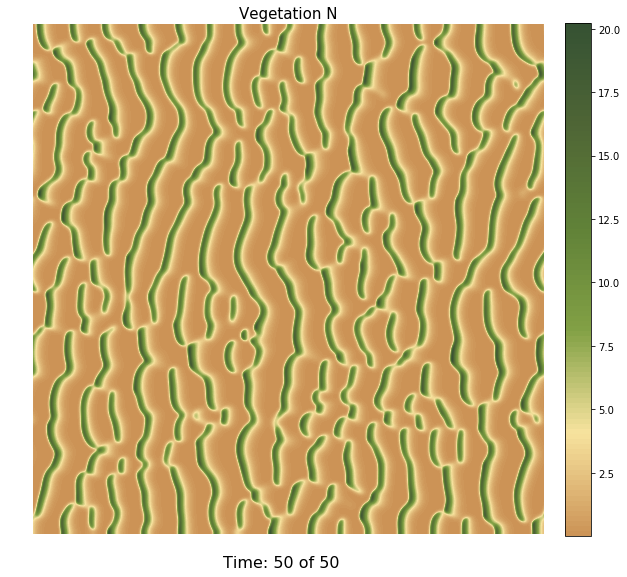

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

im=ax.imshow(Ns[:,:,NumPlots-1].T, cmap=VegMap, animated=True, interpolation='bilinear')
ax.set_title('Vegetation N', fontsize=15)
text=fig.suptitle("Time: %1.0f of %1.0f" % (EndTime, EndTime), x=0.47, y=0.12, fontsize=16);
ax.set_axis_off()

f=fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

In [13]:
from matplotlib import animation, rc

def updatefig(i): # To update the image at each iteration
    global Ns
    im.set_array(Ns[:,:,i].T)
    text.set_text("Time: %1.0f of %1.0f" % ((i+1)/NumPlots*EndTime, EndTime));
    return im,

ani = animation.FuncAnimation(fig, updatefig, interval=100, frames = NumPlots, repeat=False, blit=True)

from IPython.display import HTML
HTML(ani.to_html5_video())

Cleverly copied from: https://ipython-books.github.io/54-wrapping-a-c-library-in-python-with-ctypes/